In [3]:
from utils import *

In [5]:
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")


In [6]:
def apply_ds_clean(fn, **fn_kwargs):
    def apply(dataset):
        text = dataset["text"]
        cleaned = fn(text, **fn_kwargs)
        return {"cleaned": cleaned,
                "is_cleaned": cleaned!= text}
    return apply

In [26]:
dataset_cleaned = dataset.map(apply_ds_clean(clean_html_metadata, window_size=5, threshold=0.35))
show_diff(dataset_cleaned, n_cases=60, fname="html_cleaning.txt")


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

1) i feel pretty rotten when jake takes off down the street on his hot rod mongoose and jordan strikes out trying to chase him down like an orphan straight out of a href http en
   i feel pretty rotten when jake takes off down the street on his hot rod mongoose and jordan strikes out trying to chase him down like an orphan straight out of
2) i feel so very loved by a href http www
   i feel so very loved by
3) i feel so inspired by her motivation and passion that i wanted to share it here with you a href http
   i feel so inspired by her motivation and passion that i wanted to share it here with you
4) i did this all a href http feeling groggy
   i did this all groggy
5) i feel so empty a href http uwilnevrknow
   i feel so empty
6) im feeling generous its easy when youre giving away other peeps stuff if after you vote you visit the a href http www
   im feeling generous its easy when youre giving away other peeps stuff if after you vote you visit the
7) i feel really joyful img src ht

In [95]:
dataset_cleaned = dataset.map(apply_ds_clean(fix_missing_apostrophes))
show_diff(dataset_cleaned, n_cases=5,fname="fixed_apos.txt")


1) i feel way when meet again i ll ask you re doing and you ll say fine ask i m doing and i ll lie i ll say ordinary it s ordinary day
   i feel way when meet again i'll ask you're doing and you'll say fine ask i'm doing and i'll lie i'll say ordinary it's ordinary day
2) i feel desperately unhappy if this is me missing richard then i can t handle it it s too much i ve had enough of it i m a mess i know it s not me i still feel like myself
   i feel desperately unhappy if this is me missing richard then i can't handle it it's too much i've had enough of it i'm a mess i know it's not me i still feel like myself
3) i don t believe in my weakness he is strong i don t believe i am more than a conqueror and i feel like i m a real fake and it s not fine
   i don't believe in my weakness he is strong i don't believe i am more than a conqueror and i feel like i'm a real fake and it's not fine
4) i see a woman sitting alone at a table in starbucks or at a restaurant if i m feeling playful and c

In [78]:
dataset_cleaned = dataset.map(apply_ds_clean(normalize_slang_text))
show_diff(dataset_cleaned, "slang_norm.txt")


0) i feel romantic feelings in my soul and begging to god make u me ur love me ur feeling me ur soul me i wanna to hear the beat of heart by u for me ever if u wanna so otherwise i am nothing without u
   i feel romantic feelings in my soul and begging to god make you me your love me your feeling me your soul me i wanna to hear the beat of heart by you for me ever if you wanna so otherwise i am nothing without you
1) i always think about my past and i start crying also i can be happy then idk why but i start feeling sad
   i always think about my past and i start crying also i can be happy then i do not know why but i start feeling sad
2) i feel so empty idk i came home early from school
   i feel so empty i do not know i came home early from school
3) i feel like my meds arent working correctly and idk its weird
   i feel like my meds arent working correctly and i do not know its weird
4) i just read this on yahoo and thought it verrrrrrrryyyy interesting n n n n red may be the color 

In [79]:
dataset_cleaned = dataset.map(apply_ds_clean(fix_contructions))
show_diff(dataset_cleaned, "contructions.txt")

0) i was young but i cant get that feeling back shes got a killers grin on and maybe im just too jaded now and i wont leave ill try and pretend cause weve got nothing to lose but time so here we go again
   i was young but i cannot get that feeling back she is got a killers grin on and maybe i am just too jaded now and i will not leave ill try and pretend because we have got nothing to lose but time so here we go again
1) i feel they think im always glad but theres something they dont no im the one whos feeling sad
   i feel they think i am always glad but there is something they do not no i am the one who is feeling sad
2) i dunno the word im even looking for i guess because im not exactly how i feel im selfish i know
   i do not know the word i am even looking for i guess because i am not exactly how i feel i am selfish i know
3) i m tryin my level best be a gud pal but i cant help if u dont understad what i feel abt u dats ur problemn i don think carin for sum is a crime img src rte

In [80]:
dataset_cleaned = dataset.map(apply_ds_clean(normalize_repeated_chars))
show_diff(dataset_cleaned, "rep_chars.txt")

0) i want to be recless but im feeling so uptight put your mamma in a headlock baby and do it right whooooos got the crack whooooooooos got the crack whooooo s got the crack whos got the craaaaaaack
   i want to be recless but im feeling so uptight put your mamma in a headlock baby and do it right whoos got the crack whoos got the crack whoo s got the crack whos got the craack
1) i am so festive this feels so delicious wheeeeee what a great night
   i am so festive this feels so delicious whee what a great night
2) i shalt say we did cos i din feel a thing when he wrote hw he is keen on xxx
   i shalt say we did cos i din feel a thing when he wrote hw he is keen on xx
3) i knew it was the holy spirit at work plus it feels divine in the gooooood way like a massage reassuring me
   i knew it was the holy spirit at work plus it feels divine in the good way like a massage reassuring me
4) i was feeling really horny all afternoon with no one to fulfill ma sexual desire and only had my bed a

In [81]:

dataset_cleaned = dataset.map(apply_ds_clean(clean_sample))
show_diff(dataset_cleaned, "total.txt")

0) im feeling lucky width li style border px list style outside margin px px
   i am feeling lucky
1) i feel romantic feelings in my soul and begging to god make u me ur love me ur feeling me ur soul me i wanna to hear the beat of heart by u for me ever if u wanna so otherwise i am nothing without u
   i feel romantic feelings in my soul and begging to god make you me your love me your feeling me your soul me i want to to hear the beat of heart by you for me ever if you want to so otherwise i am nothing without you
2) i will say that a little piece of me feels agitated when i watch discussions on race and there will i style color font family georgia serif font size px line height
   i will say that a little piece of me feels agitated when i watch discussions on race and there will i
3) i m tryin my level best be a gud pal but i cant help if u dont understad what i feel abt u dats ur problemn i don think carin for sum is a crime img src rte emoticons smile sarcastic
   i am tryin my lev

In [28]:

# ctr = 0
# for t, tdf in duplicates.groupby("text"):
#     if len(set(tdf.label.tolist()))>1:
#         ctr+=1
#         print(set(tdf.label.tolist()))
# print(ctr)

In [31]:
def show_duplicates(dataset):
    df = dataset["train"].to_pandas()
    duplicates = df[df.duplicated(subset=["text"], keep=False)]

    idx2label, label2idx = load_label_mapping()
    titles = ["Labels", "Tweet"]
    max_tweet_len = 80
    max_label_len = 15
    print(f"{titles[0]:^{max_label_len}} |{titles[1]:^{max_tweet_len}}")
    print("-"*(max_label_len+max_tweet_len+3))
    ctr = 0
    for t, tdf in duplicates.groupby("text"):
        if True: #len(t) <= max_tweet_len:
            labels = "({})".format('/'.join([idx2label[idx] for idx in tdf.label.tolist()]))
            print(f"{labels:<{max_label_len}} | {t}")
            ctr += 1
            if ctr == 5:
                break
show_duplicates(dataset)

    Labels      |                                     Tweet                                      
--------------------------------------------------------------------------------------------------
(Joy/Love)      | i am not amazing or great at photography but i feel passionate about it
(Love/Joy)      | i began to feel accepted by gaia on her own terms
(Fear/Anger)    | i bet taylor swift basks in the knowledge that the boys she writes songs about probably feel tortured
(Love/Joy)      | i cant escape the tears of sadness and just true grief i feel at the loss of my sweet friend and sister
(Fear/Surprise) | i could feel myself hit this strange foggy wall


In [162]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import load_label_mapping


def plot_class_distribution(dataset_dict, label_mapping_path='classes.json', fname=None):
    """
    Plot class distribution comparison between train, validation, and test splits.
    
    Args:
        dataset_dict: DatasetDict with 'train', 'validation', and 'test' splits
        label_mapping_path: Path to JSON file containing label mappings (default: 'classes.json')
        fname: Optional file path to save the figure (without extension, will be saved as .jpg)
    """
    # Load label mapping
    idx2label, label2idx = load_label_mapping(label_mapping_path)
    
    # Extract labels for all splits
    train_labels = dataset_dict['train']['label']
    val_labels = dataset_dict['validation']['label']
    test_labels = dataset_dict['test']['label']
    
    # Count label occurrences
    train_counts = pd.Series(train_labels).value_counts().sort_index()
    val_counts = pd.Series(val_labels).value_counts().sort_index()
    test_counts = pd.Series(test_labels).value_counts().sort_index()
    
    # Normalize to get proportions
    train_proportions = train_counts / train_counts.sum()
    val_proportions = val_counts / val_counts.sum()
    test_proportions = test_counts / test_counts.sum()
    
    # Prepare data for plotting with actual label names
    label_indices = train_proportions.index.tolist()
    label_names = [idx2label[idx] for idx in label_indices]
    train_values = train_proportions.values
    val_values = val_proportions.values
    test_values = test_proportions.values
    
    # Create bar plot
    x = np.arange(len(label_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(7, 4))
    bars1 = ax.bar(x - width, train_values, width, label='Train', alpha=0.8)
    bars2 = ax.bar(x, val_values, width, label='Validation', alpha=0.8)
    bars3 = ax.bar(x + width, test_values, width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Class Label', fontsize=12)
    ax.set_ylabel('Proportion', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(label_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars (show as percentages)
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height*100:.1f}%',
                   ha='center', va='bottom', fontsize=5.5)
    
    plt.tight_layout()
    
    if fname:
        # Ensure the directory exists
        directory = os.path.dirname(fname)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        plt.savefig(f'{fname}.jpg', format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_length_distribution(dataset_dict, fname=None):
    """
    Plot text length distribution (in words) for train, validation, and test splits.
    Displays overlapping normalized histograms for comparison.
    
    Args:
        dataset_dict: DatasetDict with 'train', 'validation', and 'test' splits containing 'text' field
        fname: Optional file path to save the figure (without extension, will be saved as .jpg)
    """
    # Calculate word counts for each split
    train_lengths = [len(text.split()) for text in dataset_dict['train']['text']]
    val_lengths = [len(text.split()) for text in dataset_dict['validation']['text']]
    test_lengths = [len(text.split()) for text in dataset_dict['test']['text']]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(7, 4))
    
    # Determine common bins for all plots
    all_lengths = train_lengths + val_lengths + test_lengths
    bins = np.linspace(0, max(all_lengths), 50)
    
    # Plot overlapping histograms with normalization (density=True)
    ax.hist(train_lengths, bins=bins, color='skyblue', edgecolor='black', 
            alpha=0.5, label='Train', density=True)
    ax.hist(val_lengths, bins=bins, color='lightgreen', edgecolor='black', 
            alpha=0.5, label='Validation', density=True)
    ax.hist(test_lengths, bins=bins, color='lightcoral', edgecolor='black', 
            alpha=0.5, label='Test', density=True)
    
    ax.set_xlabel('Text Length (words)', fontsize=12)
    ax.set_ylabel('Normalized Frequency (Density)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add statistics box
    stats_text = f'Train: Mean={np.mean(train_lengths):.1f}, Median={np.median(train_lengths):.1f}\n'
    stats_text += f'Val: Mean={np.mean(val_lengths):.1f}, Median={np.median(val_lengths):.1f}\n'
    stats_text += f'Test: Mean={np.mean(test_lengths):.1f}, Median={np.median(test_lengths):.1f}'
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.tight_layout()
    
    if fname:
        # Ensure the directory exists
        directory = os.path.dirname(fname)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        plt.savefig(f'{fname}.jpg', format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()


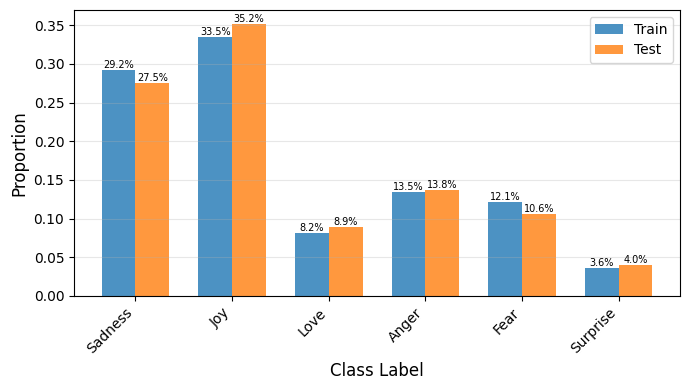

In [140]:
plot_class_distribution(dataset, fname="plots/class_dist")

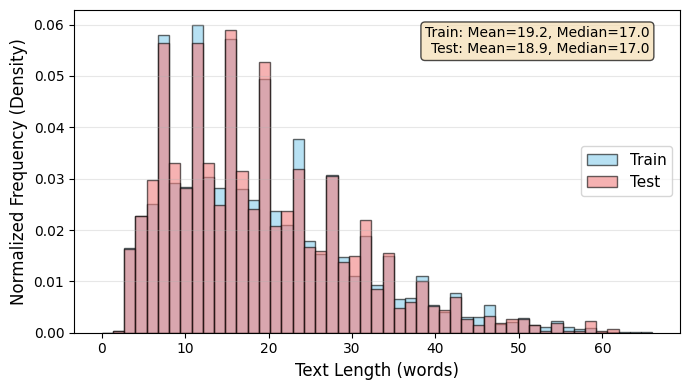

In [141]:
plot_length_distribution(dataset, fname="plots/len_dist")

In [144]:
_, tokenizer = load_hf_classifier("google/electra-small-discriminator", 6, False)
dataset_w_val = preprocess(dataset, tokenizer)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15938 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/12750 [00:00<?, ? examples/s]

Map:   0%|          | 0/3188 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

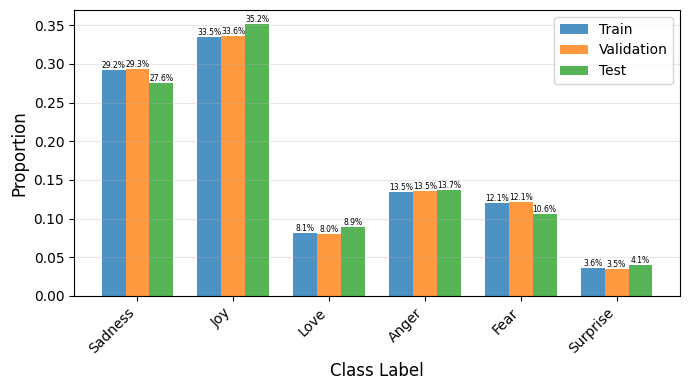

In [163]:
plot_class_distribution(dataset_w_val, fname="plots/class_dist_w_val")

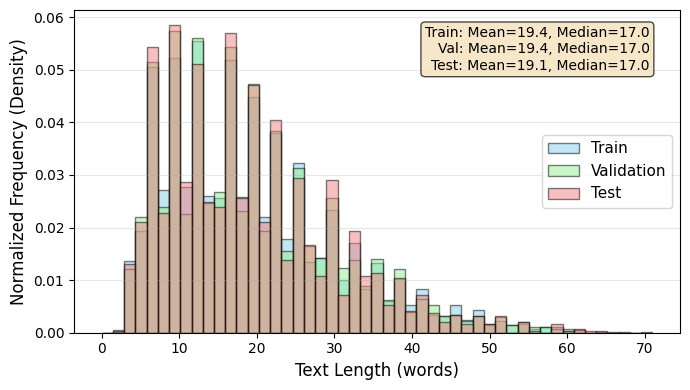

In [161]:
plot_length_distribution(dataset_w_val, fname="plots/len_dist_w_val")

In [73]:
def plot_feature_comparison(pretrained_model_paths, finetuned_model_paths, dataset, 
                            label_mapping_path='classes.json', fname=None, 
                            selected_model=None, selected_model_fpath=None,
                            method='tsne', features_cache_dir='features',
                            metrics_cache_file='feature_separability_metrics.json'):
    """
    Extract features from pretrained and finetuned model pairs, reduce dimensionality to 2D, 
    and create scatter plots colored by label.
    
    Args:
        pretrained_model_paths: List of paths to pretrained models or dict {model_name: model_path}
        finetuned_model_paths: List of paths to finetuned models or dict {model_name: model_path}
        dataset: HuggingFace Dataset with 'text' and 'label' fields
        label_mapping_path: Path to JSON file containing label mappings (default: 'classes.json')
        fname: Optional file path to save the entire figure (without extension, will be saved as .jpg)
        selected_model: Optional model name to save separately (should be in one of the model lists)
        selected_model_fpath: File path to save the selected model's plot separately (without extension)
        method: Dimensionality reduction method - 'tsne', 'pca', or 'umap' (default: 'tsne')
        features_cache_dir: Directory to cache extracted features (default: 'features')
        metrics_cache_file: JSON file to cache all separability metrics (default: 'feature_separability_metrics.json')
    """
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
    from sklearn.cluster import KMeans
    from tqdm import tqdm
    
    def extract_model_name(path):
        """Extract model name from path like 'google/electra-small-discriminator' -> 'electra-small'"""
        # Get the last part of the path
        model_part = path.rstrip('/').split('/')[-1]
        # Extract first two parts separated by '-'
        parts = model_part.split('-')
        if len(parts) >= 2:
            return '-'.join(parts[:2])
        return model_part
    
    # Convert to dicts if they're lists
    if isinstance(pretrained_model_paths, list):
        pretrained_dict = {extract_model_name(path): path for path in pretrained_model_paths}
    else:
        pretrained_dict = pretrained_model_paths
    
    if isinstance(finetuned_model_paths, list):
        finetuned_dict = {extract_model_name(path): path for path in finetuned_model_paths}
    else:
        finetuned_dict = finetuned_model_paths
    
    # Ensure same number of models
    if len(pretrained_dict) != len(finetuned_dict):
        raise ValueError("Number of pretrained and finetuned models must match")
    
    # Load label mapping
    idx2label, label2idx = load_label_mapping(label_mapping_path)
    
    # Clean dataset text
    dataset = dataset.map(clean_text)
    
    labels = dataset['label']
    unique_labels = sorted(set(labels))
    
    # Create color map
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load metrics cache
    if os.path.exists(metrics_cache_file):
        with open(metrics_cache_file, 'r') as f:
            all_metrics = json.load(f)
    else:
        all_metrics = {}
    
    def get_cache_path(model_name, model_type):
        """Generate cache file path for features"""
        os.makedirs(features_cache_dir, exist_ok=True)
        safe_name = model_name.replace('/', '_')
        return os.path.join(features_cache_dir, f"{safe_name}_{model_type}_{method}.npy")
    
    def save_metrics_to_cache(model_name, model_type, metrics):
        """Save metrics to the global metrics cache file"""
        # Create hierarchy: model-name >> method >> metrics
        model_key = f"{model_name}_{model_type}"
        if model_key not in all_metrics:
            all_metrics[model_key] = {}
        all_metrics[model_key][method] = metrics
        
        # Save to file
        with open(metrics_cache_file, 'w') as f:
            json.dump(all_metrics, f, indent=2)
    
    def get_metrics_from_cache(model_name, model_type):
        """Get metrics from the global metrics cache file"""
        model_key = f"{model_name}_{model_type}"
        if model_key in all_metrics and method in all_metrics[model_key]:
            return all_metrics[model_key][method]
        return None
    
    def calculate_separability_metrics(features_2d, labels_array):
        """Calculate separability metrics for the reduced features using ground truth labels"""
        # Perform KMeans clustering with the same number of clusters as unique labels
        n_clusters = len(np.unique(labels_array))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features_2d)
        
        # Calculate ARI and AMI comparing clusters to ground truth
        metrics = {
            'adjusted_rand_index': float(adjusted_rand_score(labels_array, cluster_labels)),
            'adjusted_mutual_info': float(adjusted_mutual_info_score(labels_array, cluster_labels))
        }
        return metrics
    
    def extract_and_reduce_features(model_path, model_name, model_type="finetuned"):
        """Extract features and apply dimensionality reduction with caching"""
        cache_path = get_cache_path(model_name, model_type)
        
        # Check cache
        if os.path.exists(cache_path):
            print(f"Loading cached {method.upper()} features for {model_name} ({model_type})")
            features_2d = np.load(cache_path)
            
            # Check if metrics are cached
            metrics = get_metrics_from_cache(model_name, model_type)
            if metrics:
                print(f"Loading cached metrics for {model_name} ({model_type})")
            else:
                # Calculate and cache metrics
                print(f"Calculating separability metrics for {model_name} ({model_type})")
                metrics = calculate_separability_metrics(features_2d, np.array(labels))
                save_metrics_to_cache(model_name, model_type, metrics)
            
            return features_2d, metrics
        
        print(f"Extracting features for {model_name} ({model_type})...")
        
        # Load model and tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        model.eval()
        model.to(device)
        
        # Extract features
        features = []
        with torch.no_grad():
            for text in tqdm(dataset['text'], desc=f"Extracting {model_name}"):
                inputs = tokenizer(text, return_tensors='pt', truncation=True, 
                                 max_length=512, padding=True)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                outputs = model(**inputs, output_hidden_states=True)
                hidden_state = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
                features.append(hidden_state.squeeze())
        
        features = np.array(features)
        
        # Apply dimensionality reduction
        print(f"Applying {method.upper()} reduction for {model_name}...")
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
            features_2d = reducer.fit_transform(features)
        elif method.lower() == 'pca':
            reducer = PCA(n_components=2, random_state=42)
            features_2d = reducer.fit_transform(features)
        elif method.lower() == 'umap':
            try:
                from umap import UMAP
                reducer = UMAP(n_components=2, random_state=42)
                features_2d = reducer.fit_transform(features)
            except ImportError:
                print("UMAP not installed. Falling back to t-SNE.")
                reducer = TSNE(n_components=2, random_state=42, perplexity=30)
                features_2d = reducer.fit_transform(features)
        else:
            raise ValueError(f"Unknown method: {method}. Choose from 'tsne', 'pca', or 'umap'.")
        
        # Cache the results
        np.save(cache_path, features_2d)
        print(f"Cached features to {cache_path}")
        
        # Calculate and cache separability metrics
        print(f"Calculating separability metrics for {model_name} ({model_type})")
        metrics = calculate_separability_metrics(features_2d, np.array(labels))
        save_metrics_to_cache(model_name, model_type, metrics)
        print(f"Cached metrics to {metrics_cache_file}")
        
        return features_2d, metrics
    
    def plot_scatter(ax, features_2d, title, metrics=None):
        """Plot scatter plot on given axes"""
        for label in unique_labels:
            mask = np.array(labels) == label
            ax.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                      c=[color_map[label]], label=idx2label[label], 
                      alpha=0.6, s=25, edgecolors='black', linewidth=0.5)
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{method.upper()} Component 1', fontsize=8)
        ax.set_ylabel(f'{method.upper()} Component 2', fontsize=8)
        ax.legend(fontsize=6, loc='lower right')
        ax.grid(True, alpha=0.3)
        
        # Add metrics text box if provided
        if metrics:
            metrics_text = (
                f"ARI: {metrics['adjusted_rand_index']:.3f}\n"
                f"AMI: {metrics['adjusted_mutual_info']:.3f}"
            )
            ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
                   fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Extract features for all model pairs
    model_pairs = []
    selected_pair = None
    
    pretrained_list = list(pretrained_dict.items())
    finetuned_list = list(finetuned_dict.items())
    
    # Find selected model if specified
    selected_model_name = None
    if selected_model:
        selected_model_name = extract_model_name(selected_model)
    
    for (pre_name, pre_path), (fine_name, fine_path) in zip(pretrained_list, finetuned_list):
        # Extract features
        pre_features, pre_metrics = extract_and_reduce_features(pre_path, pre_name, "pretrained")
        fine_features, fine_metrics = extract_and_reduce_features(fine_path, fine_name, "finetuned")
        
        model_pairs.append({
            'pretrained_name': pre_name,
            'finetuned_name': fine_name,
            'pretrained_features': pre_features,
            'finetuned_features': fine_features,
            'pretrained_metrics': pre_metrics,
            'finetuned_metrics': fine_metrics
        })
        
        # Check if this is the selected model pair
        if selected_model_name and (selected_model_name == pre_name or selected_model_name == fine_name):
            selected_pair = model_pairs[-1]
    
    # Print separability metrics summary
    print("\n=== Separability Metrics Summary ===")
    for pair in model_pairs:
        print(f"\nModel: {pair['pretrained_name']}")
        print(f"  Pretrained:")
        print(f"    Adjusted Rand Index: {pair['pretrained_metrics']['adjusted_rand_index']:.4f}")
        print(f"    Adjusted Mutual Info: {pair['pretrained_metrics']['adjusted_mutual_info']:.4f}")
        print(f"  Finetuned:")
        print(f"    Adjusted Rand Index: {pair['finetuned_metrics']['adjusted_rand_index']:.4f}")
        print(f"    Adjusted Mutual Info: {pair['finetuned_metrics']['adjusted_mutual_info']:.4f}")
    
    # If selected_model is specified and found, save it separately
    if selected_model and selected_model_fpath and selected_pair:
        fig_single, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
        
        plot_scatter(ax1, selected_pair['pretrained_features'], selected_pair['pretrained_name'], 
                    selected_pair['pretrained_metrics'])
        plot_scatter(ax2, selected_pair['finetuned_features'], selected_pair['finetuned_name'],
                    selected_pair['finetuned_metrics'])
        
        plt.tight_layout()
        
        # Save selected model plot
        directory = os.path.dirname(selected_model_fpath)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        plt.savefig(f'{selected_model_fpath}.jpg', format='jpg', dpi=200, bbox_inches='tight')
        plt.close(fig_single)
    
    # Create grid plot for all model pairs
    n_pairs = len(model_pairs)
    n_cols = 2
    n_rows = n_pairs
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4 * n_rows))
    
    # Flatten axes array if needed
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Plot all pairs
    for idx, pair in enumerate(model_pairs):
        plot_scatter(axes[idx, 0], pair['pretrained_features'], pair['pretrained_name'],
                    pair['pretrained_metrics'])
        plot_scatter(axes[idx, 1], pair['finetuned_features'], pair['finetuned_name'],
                    pair['finetuned_metrics'])
    
    plt.tight_layout()
    
    if fname:
        # Ensure the directory exists
        directory = os.path.dirname(fname)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        plt.savefig(f'{fname}.jpg', format='jpg', dpi=200, bbox_inches='tight')
    
    plt.show()

Loading cached TSNE features for electra-small (pretrained)
Loading cached metrics for electra-small (pretrained)
Loading cached TSNE features for electra-small (finetuned)
Loading cached metrics for electra-small (finetuned)
Loading cached TSNE features for electra-base (pretrained)
Loading cached metrics for electra-base (pretrained)
Loading cached TSNE features for electra-base (finetuned)
Loading cached metrics for electra-base (finetuned)
Loading cached TSNE features for roberta-base (pretrained)
Loading cached metrics for roberta-base (pretrained)
Loading cached TSNE features for roberta-base (finetuned)
Loading cached metrics for roberta-base (finetuned)
Loading cached TSNE features for deberta-base (pretrained)
Loading cached metrics for deberta-base (pretrained)
Loading cached TSNE features for deberta-base (finetuned)
Loading cached metrics for deberta-base (finetuned)
Loading cached TSNE features for roberta-large (pretrained)
Loading cached metrics for roberta-large (pretra

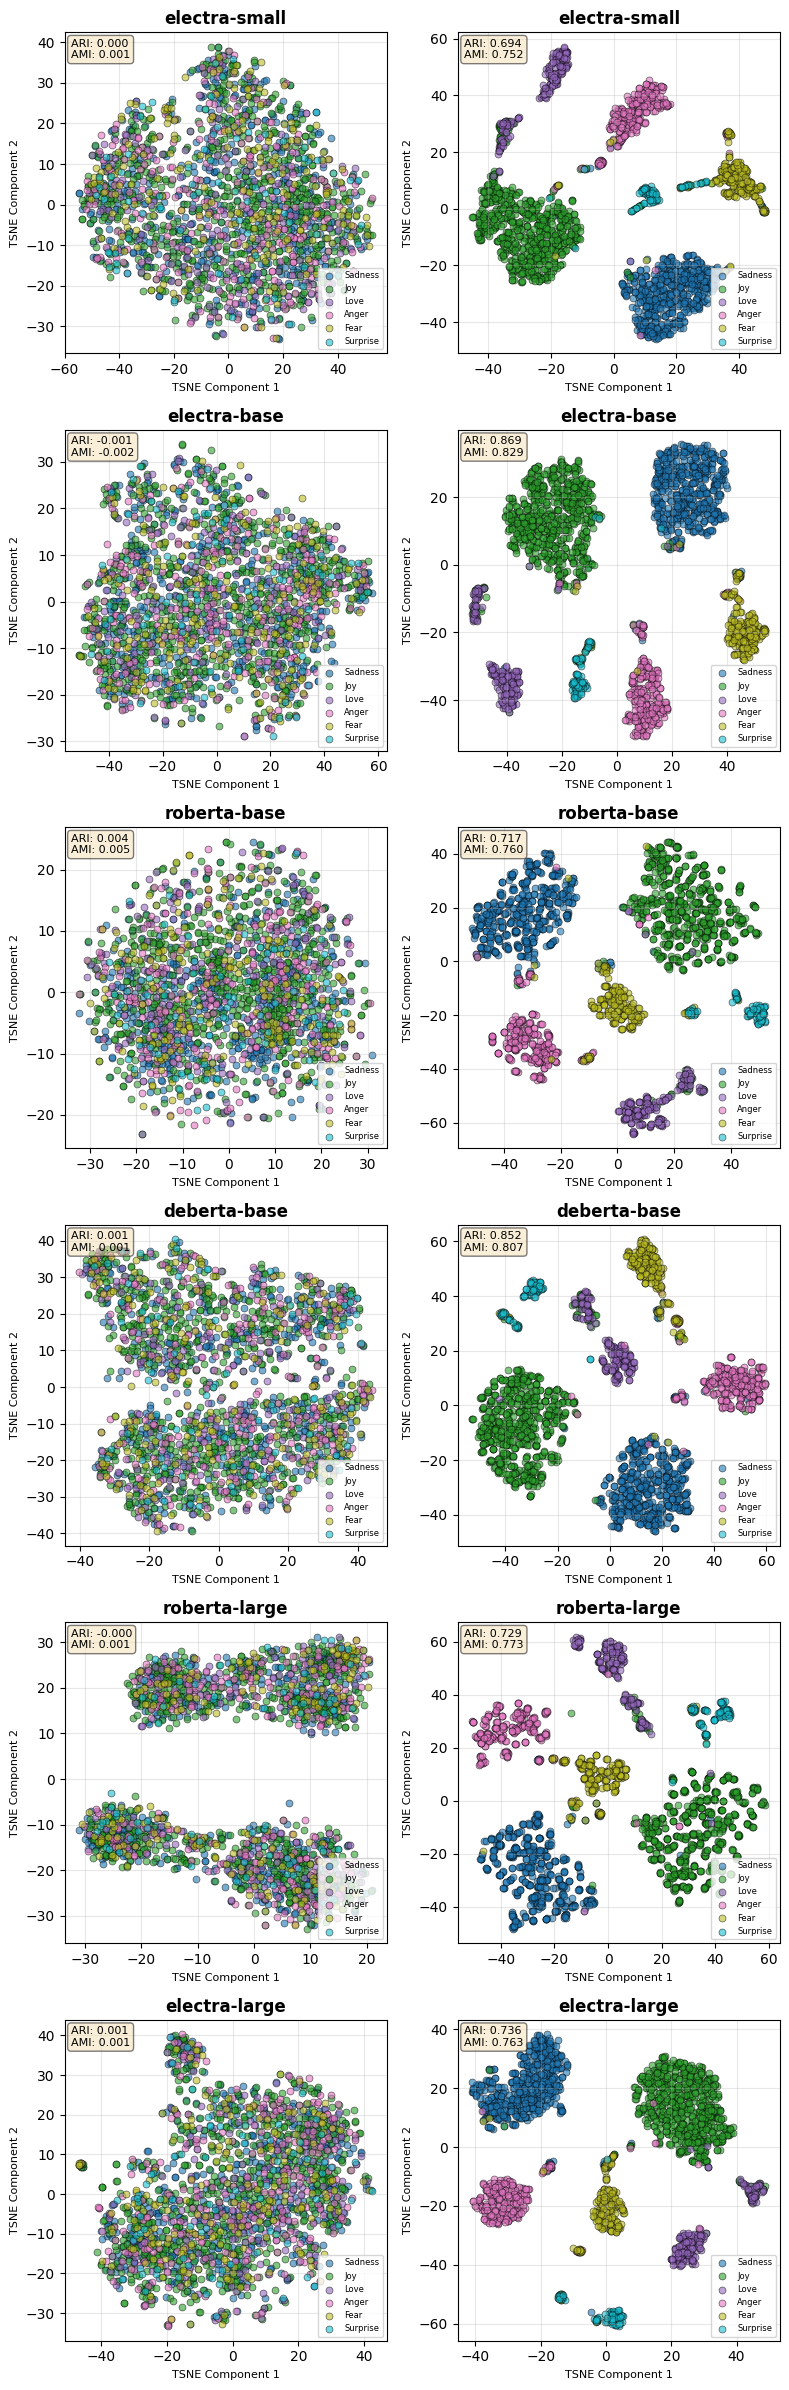

In [74]:
model_names = [
         "google/electra-small-discriminator",
         "google/electra-base-discriminator",
         "FacebookAI/roberta-base",
         "microsoft/deberta-base",
         "FacebookAI/roberta-large",
         "google/electra-large-discriminator",
]
trained_models = [
                 "nisimachluf/electra-small-tweet-classification",
                 "nisimachluf/electra-base-tweet-classification",
                 "nisimachluf/roberta-base-tweet-classification",
                 "nisimachluf/deberta-base-tweet-classification",
                 "nisimachluf/roberta-large-tweet-classification",
                 "nisimachluf/electra-large-tweet-classification",
]
plot_feature_comparison(model_names, trained_models, dataset["test"], 
                            label_mapping_path='classes.json', fname="feature_separation", 
                            selected_model="nisimachluf/electra-large-tweet-classification", selected_model_fpath="feature_separation-electra_large",
                            method='tsne', features_cache_dir='features')

True